# Popularity of the president

This notebook is used to update the results of the president popularity model when new data arrives. We quickly validate the data, fit the model, run model diagnostics and export the data needed for the dashboard.

**We may want to run some analyses on the difference between the fit including the last data point and the previous fit.**

In [1]:
import datetime
import warnings

import arviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as aet
from scipy.special import expit as logistic

warnings.filterwarnings('ignore')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# hide
RANDOM_SEED = 926
np.random.seed(RANDOM_SEED)
arviz.style.use("arviz-darkgrid")

## Load and clean the data

In [3]:
data = pd.read_csv(
    "https://raw.githubusercontent.com/AlexAndorra/pollsposition_models/master/data/raw_popularity_presidents.csv",
    header=0,
    index_col=0,
    parse_dates=True,
)

In [4]:
# Restrict data to after the switch to 5-year term
data = data.loc[data.index >= pd.to_datetime("2002-05-05")]
data["year"] = data.index.year
data["month"] = data.index.month

# Correct a few typos in the dataset
data["sondage"] = data["sondage"].replace("Yougov", "YouGov")
data["method"] = data["method"].replace("face-to-face&internet", "face to face")

# Convert approvals rates to proportion and compute total num approval
data[["approve_pr", "disapprove_pr"]] = (
    data[["approve_pr", "disapprove_pr"]].copy() / 100
)
data = data.rename(columns={"approve_pr": "p_approve", "disapprove_pr": "p_disapprove"})
data["num_approve"] = np.floor(data["samplesize"] * data["p_approve"]).astype("int")

# Reset the index
data = data.reset_index().rename(columns={"index": "field_date"})

Let's quickly summarize the data:

In [6]:
POLLSTERS = data["sondage"].sort_values().unique()
comment = f"""The dataset contains {len(data)} polls between the years {data["year"].min()} and {data["year"].max()}.
There are {len(POLLSTERS)} pollsters: {', '.join(list(POLLSTERS))}
"""
print(comment)

The dataset contains 1083 polls between the years 2002 and 2021.
There are 10 pollsters: BVA, Elabe, Harris, Ifop, Ipsos, Kantar, Odoxa, OpinionWay, Viavoice, YouGov



## Sanity checks

We need to check that we haven't introduced any typos in the pollsters or methods, and do a quick visual check on the most recent approval values.

In [7]:
pd.crosstab(data.sondage, data.method, margins=True)

method,face to face,internet,phone,phone&internet,All
sondage,,,,,
BVA,0,101,89,0,190
Elabe,0,52,0,0,52
Harris,0,33,0,0,33
Ifop,0,29,181,38,248
Ipsos,0,40,177,0,217
Kantar,208,4,0,0,212
Odoxa,0,67,0,0,67
OpinionWay,0,12,0,0,12
Viavoice,0,20,0,0,20


Now let's plot the polls' results for Macron's term and highlight the last three points:

Text(0.5, 0, 'Date')

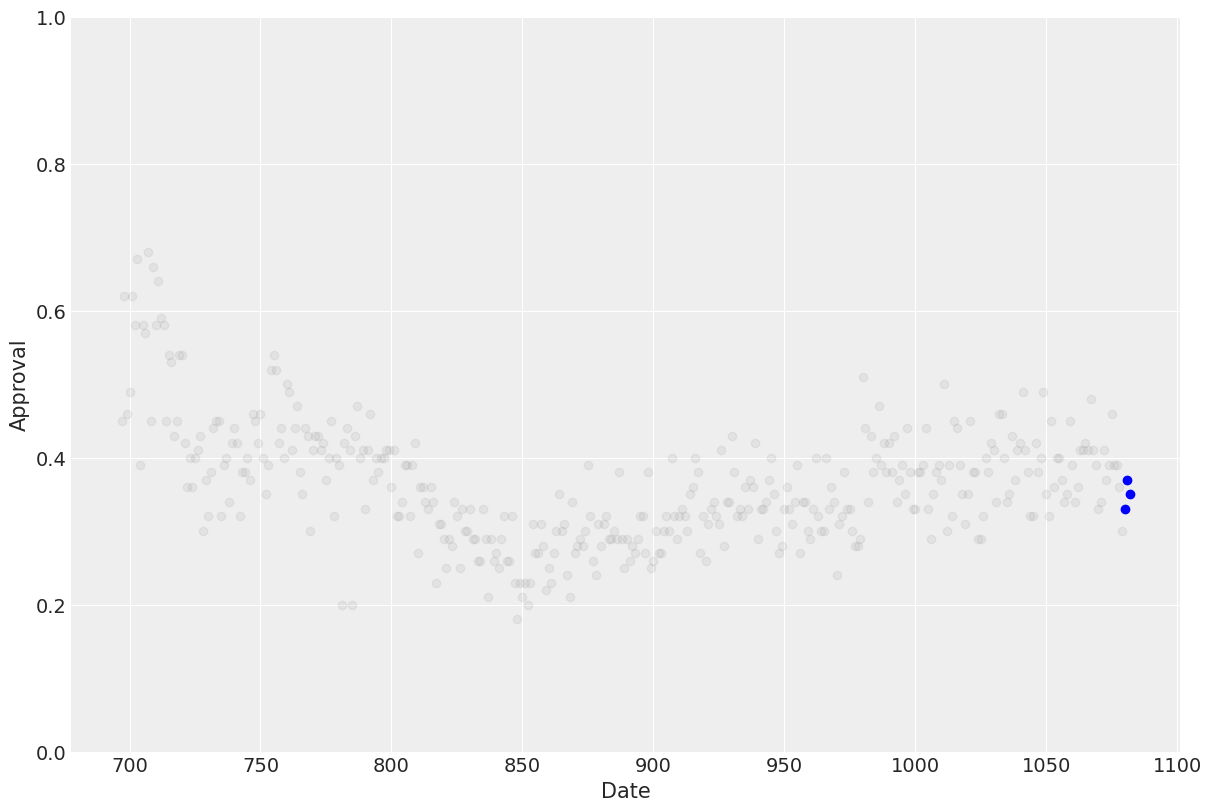

In [7]:
approval = data.loc[data.president == 'macron']["p_approve"].values
dates = data.loc[data.president == 'macron'].index

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(dates[:-3], approval[:-3], "o", color='grey', alpha=0.1)
ax.plot(dates[-3:], approval[-3:], "o", color='blue')
ax.set_ylim(0, 1)
ax.set_ylabel("Approval")
ax.set_xlabel("Date")

## Model

Let's prepare the data for the model:

In [8]:
pollster_by_method_id, pollster_by_methods = data.set_index(
    ["sondage", "method"]
).index.factorize(sort=True)

month_id = np.hstack(
    [
        pd.Categorical(
            data[data.president == president].field_date.dt.to_period("M")
        ).codes
        for president in data.president.unique()
    ]
)
months = np.arange(max(month_id) + 1)
data["month_id"] = month_id

president_id, presidents = data["president"].factorize(sort=False)

COORDS = {
    "pollster_by_method": pollster_by_methods,
    "month": months,
    "month_minus_origin": months[1:],
    "president": presidents,
    "observation": data.set_index(["sondage", "field_date"]).index,
}

Define the `ZeroSumNormal` distribution

In [9]:
from typing import *


def ZeroSumNormal(
    name: str,
    sigma: float = 1.0,
    *,
    dims: Union[str, Tuple[str]],
    model: Optional[pm.Model] = None,
):
    """
    Multivariate normal, such that sum(x, axis=-1) = 0.

    Parameters

    name: str
        String name representation of the PyMC variable.
    sigma: float, defaults to 1
        Scale for the Normal distribution. If none is provided, a standard Normal is used.
    dims: Union[str, Tuple[str]]
        Dimension names for the shape of the distribution.
        See https://docs.pymc.io/pymc-examples/examples/pymc3_howto/data_container.html for an example.
    model: Optional[pm.Model], defaults to None
        PyMC model instance. If ``None``, a model instance is created.

    Notes
    ----------
    Contributed by Adrian Seyboldt (@aseyboldt).
    """
    if isinstance(dims, str):
        dims = (dims,)

    model = pm.modelcontext(model)
    *dims_pre, dim = dims
    dim_trunc = f"{dim}_truncated_"
    (shape,) = model.shape_from_dims((dim,))
    assert shape >= 1

    model.add_coords({f"{dim}_truncated_": pd.RangeIndex(shape - 1)})
    raw = pm.Normal(
        f"{name}_truncated_", dims=tuple(dims_pre) + (dim_trunc,), sigma=sigma
    )
    Q = make_sum_zero_hh(shape)
    draws = aet.dot(raw, Q[:, 1:].T)

    return pm.Deterministic(name, draws, dims=dims)


def make_sum_zero_hh(N: int) -> np.ndarray:
    """
    Build a householder transformation matrix that maps e_1 to a vector of all 1s.
    """
    e_1 = np.zeros(N)
    e_1[0] = 1
    a = np.ones(N)
    a /= np.sqrt(a @ a)
    v = a + e_1
    v /= np.sqrt(v @ v)
    return np.eye(N) - 2 * np.outer(v, v)

And, finally, the model:

In [10]:
with pm.Model(coords=COORDS) as hierarchical_popularity:

    baseline = pm.Normal("baseline")
    president_effect = ZeroSumNormal("president_effect", sigma=0.15, dims="president")
    house_effect = ZeroSumNormal("house_effect", sigma=0.15, dims="pollster_by_method")
    month_effect = ZeroSumNormal("month_effect", sigma=0.15, dims="month")

    # need the cumsum parametrization to properly control the init of the GRW
    rw_init = aet.zeros(shape=(len(COORDS["president"]), 1))
    rw_innovations = pm.Normal(
        "rw_innovations",
        dims=("president", "month_minus_origin"),
    )
    raw_rw = aet.cumsum(aet.concatenate([rw_init, rw_innovations], axis=-1), axis=-1)
    sd = pm.HalfNormal("shrinkage_pop", 0.2)
    month_president_effect = pm.Deterministic(
        "month_president_effect", raw_rw * sd, dims=("president", "month")
    )

    popularity = pm.math.invlogit(
        baseline
        + president_effect[president_id]
        + month_effect[month_id]
        + month_president_effect[president_id, month_id]
        + house_effect[pollster_by_method_id]
    )

    # overdispersion parameter
    theta = pm.Exponential("theta_offset", 1.0) + 10.0

    N_approve = pm.BetaBinomial(
        "N_approve",
        alpha=popularity * theta,
        beta=(1.0 - popularity) * theta,
        n=data["samplesize"],
        observed=data["num_approve"],
        dims="observation",
    )

In [11]:
with hierarchical_popularity:
    idata = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta_offset, shrinkage_pop, rw_innovations, month_effect_truncated_, house_effect_truncated_, president_effect_truncated_, baseline]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 109 seconds.


0, dim: observation, 1083 =? 1083


Let's make sure the trace looks good:

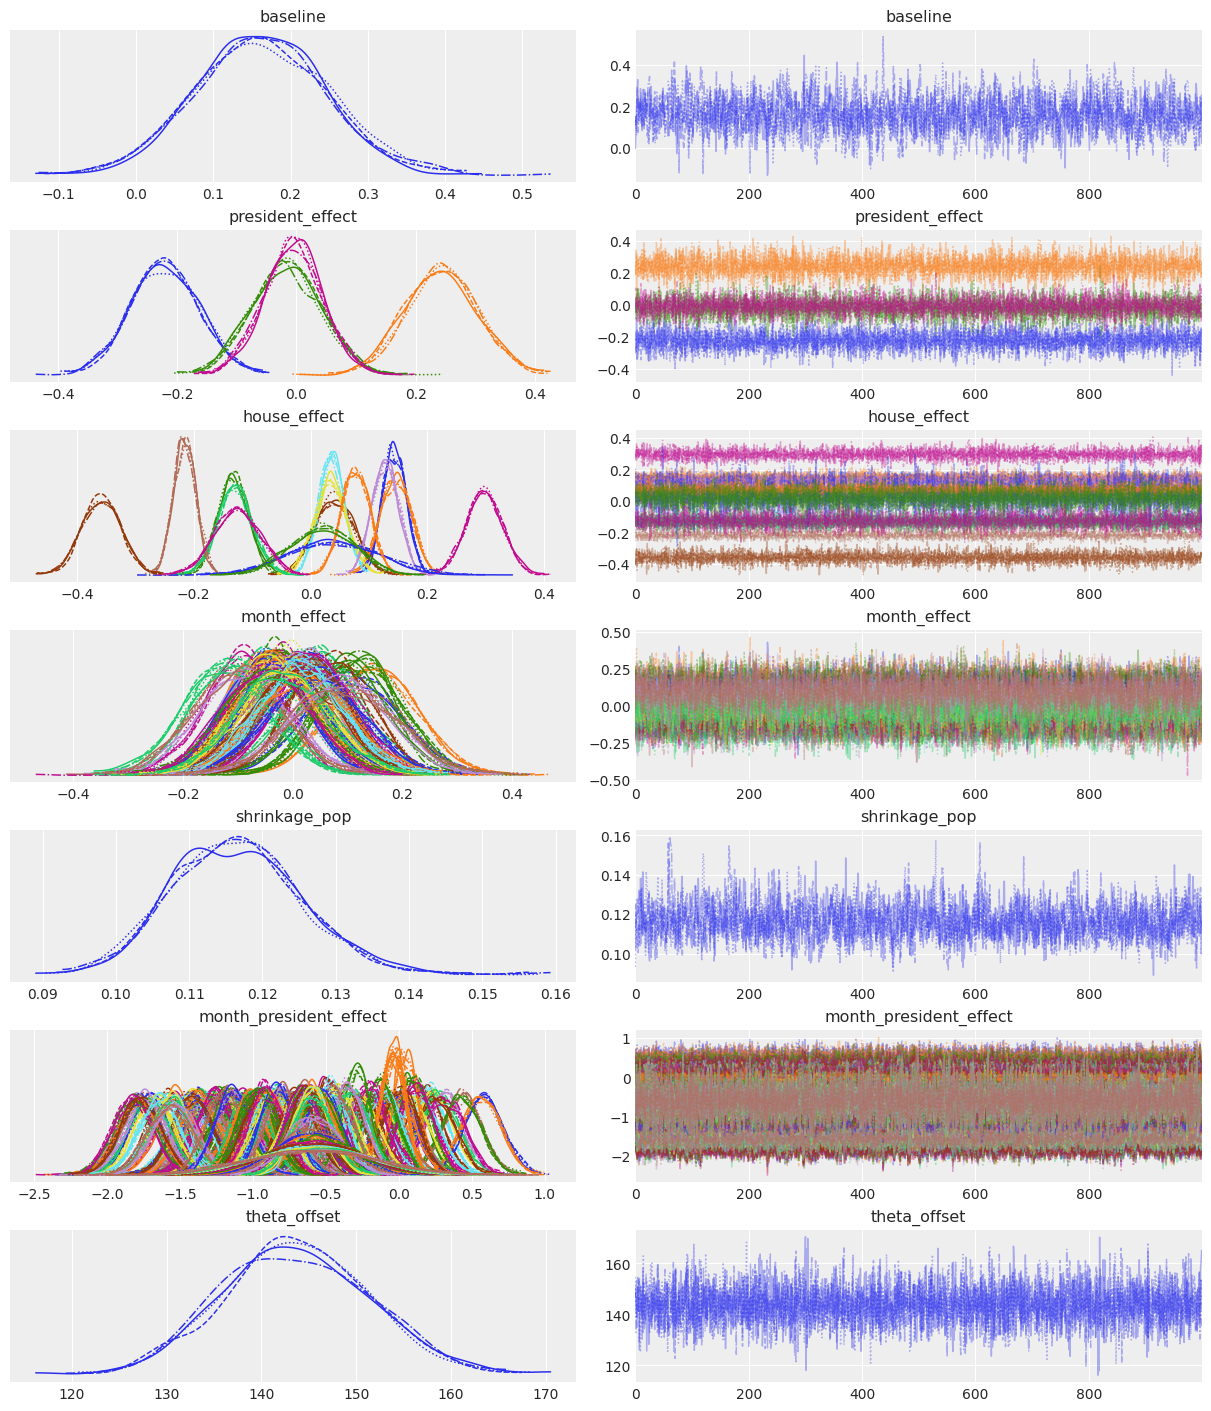

In [12]:
arviz.plot_trace(
    idata,
    var_names=["~truncated", "~rw_innovations"],
    filter_vars="regex",
    compact=True,
);

And check the number of effective samples and $\hat{R}$

In [13]:
arviz.summary(
    idata,
    round_to=2,
    var_names=["~truncated", "~rw_innovations"],
    filter_vars="regex",
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
baseline,0.16,0.08,-0.00,0.32,0.00,0.00,1783.14,2223.52,1.0
president_effect[0],-0.22,0.06,-0.33,-0.12,0.00,0.00,4795.08,2762.04,1.0
president_effect[1],0.24,0.06,0.14,0.36,0.00,0.00,6058.31,2779.23,1.0
president_effect[2],-0.02,0.06,-0.13,0.09,0.00,0.00,4887.77,3249.70,1.0
president_effect[3],-0.01,0.05,-0.10,0.09,0.00,0.00,4779.26,3005.80,1.0
...,...,...,...,...,...,...,...,...,...
"month_president_effect[3,56]",-0.59,0.38,-1.31,0.13,0.01,0.00,5019.29,2814.03,1.0
"month_president_effect[3,57]",-0.59,0.40,-1.38,0.12,0.01,0.00,5105.77,2901.66,1.0
"month_president_effect[3,58]",-0.59,0.42,-1.39,0.16,0.01,0.00,5512.20,3104.20,1.0
"month_president_effect[3,59]",-0.59,0.43,-1.43,0.19,0.01,0.01,5661.03,2998.64,1.0


## Posterior estimations

Let's keep an eye on the biaises:

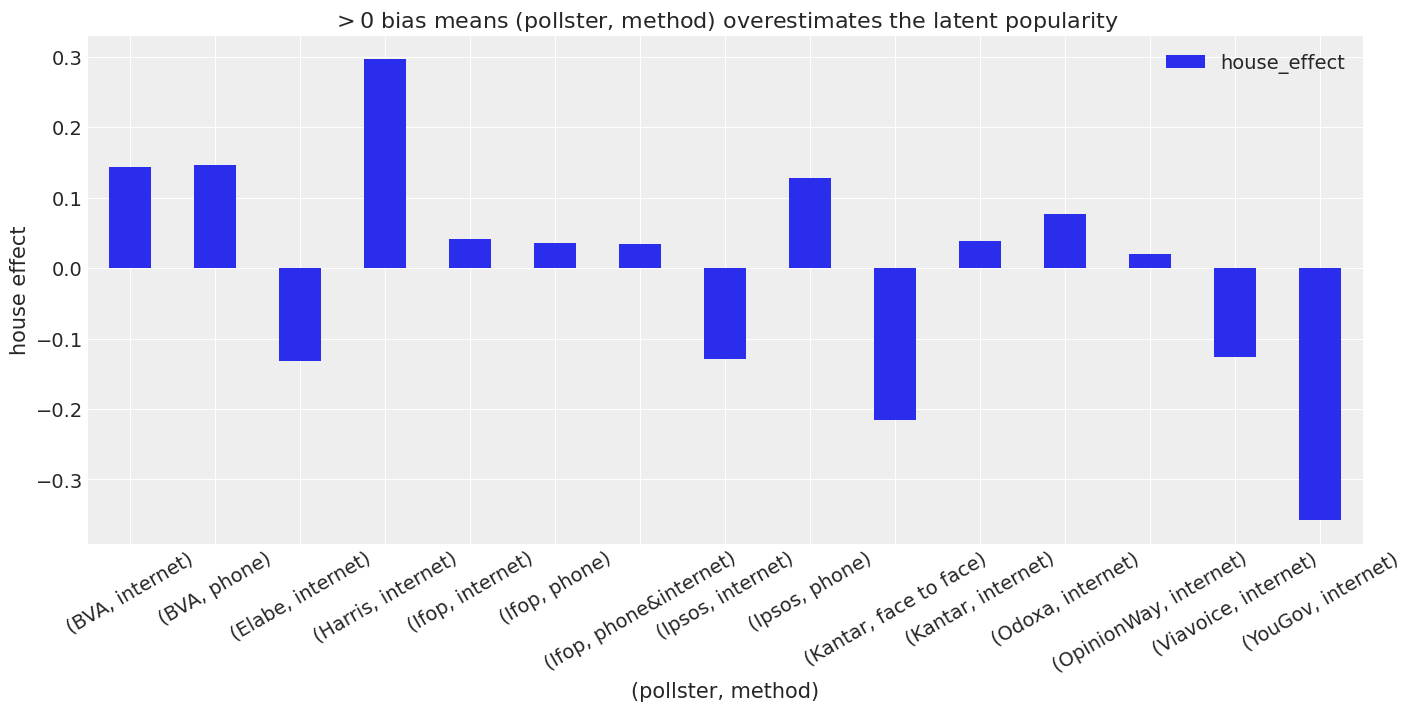

In [14]:
mean_house_effect = (
    idata.posterior["house_effect"].mean(("chain", "draw")).to_dataframe()
)
ax = mean_house_effect.plot.bar(figsize=(14, 7), rot=30)
ax.set_xlabel("(pollster, method)")
ax.set_ylabel("house effect")
ax.set_title("$>0$ bias means (pollster, method) overestimates the latent popularity");

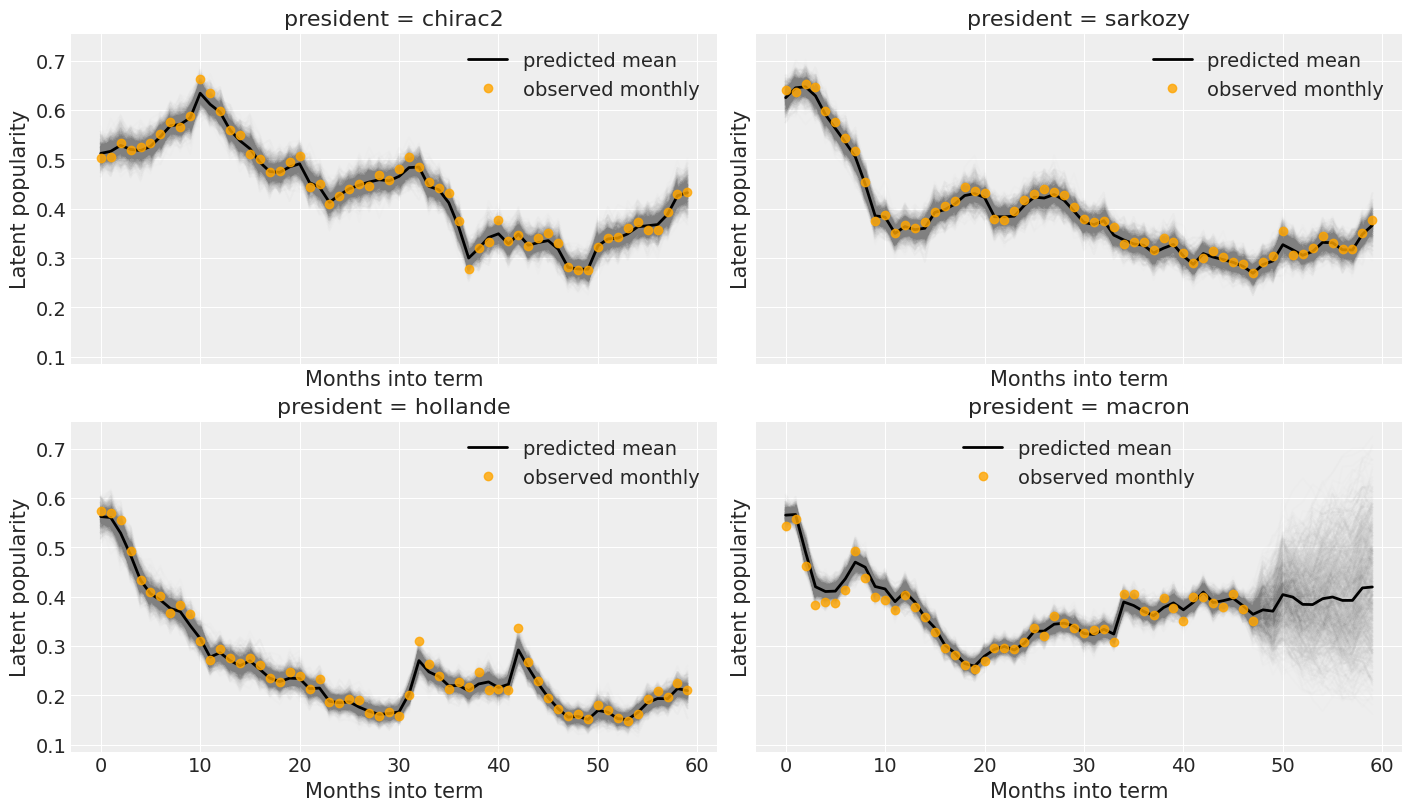

In [15]:
data = data.merge(
        data.groupby(["year", "month"])["p_approve"].mean().reset_index(),
        on=["year", "month"],
        suffixes=["", "_mean"],
)
obs_mean = data.groupby(["president", "month_id"]).last()["p_approve_mean"].unstack().T

fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True, sharey=True)

for ax, p in zip(axes.ravel(), idata.posterior.coords["president"]):
    post = idata.posterior.sel(president=p)
    post_pop = logistic(
        (
            post["baseline"]
            + post["president_effect"]
            + post["month_effect"]
            + post["month_president_effect"]
        ).stack(sample=("chain", "draw"))
    )
    # plot random posterior draws
    ax.plot(
        post.coords["month"],
        post_pop.isel(
            sample=np.random.choice(post_pop.coords["sample"].size, size=1000)
        ),
        alpha=0.01,
        color="grey",
    )
    # plot posterior mean
    post_pop.mean("sample").plot(ax=ax, color="black", lw=2, label="predicted mean")
    # plot monthly raw polls
    ax.plot(
        obs_mean.index,
        obs_mean[p.data],
        "o",
        color="orange",
        alpha=0.8,
        label="observed monthly",
    )
    ax.set_xlabel("Months into term")
    ax.set_ylabel("Latent popularity")
    ax.legend()

## Posterior predictions

We look at the posterior predictive distributions, again to make sure that the model has correctly sampled.

In [16]:
with hierarchical_popularity:
    idata.extend(
        arviz.from_pymc3(
            posterior_predictive=pm.sample_posterior_predictive(idata),
        )
    )

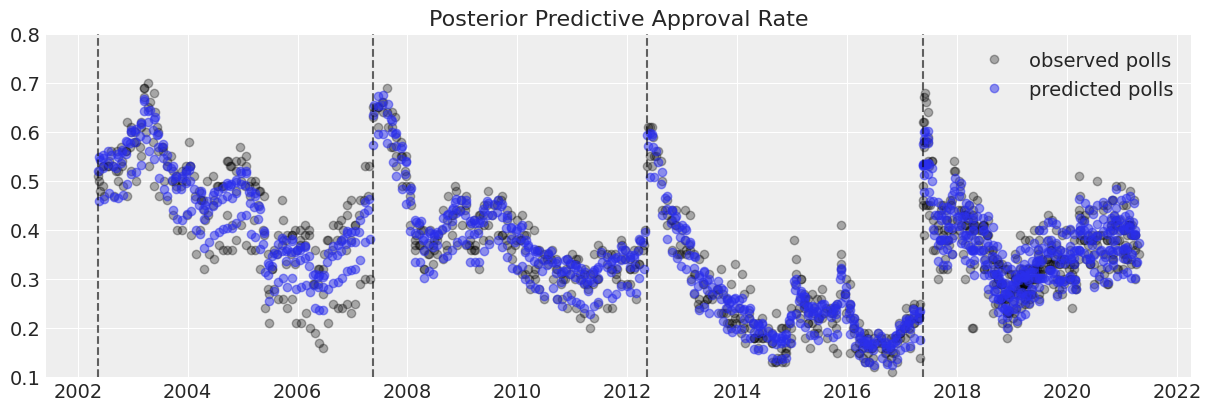

In [17]:
predicted_approval_rates = (
    idata.posterior_predictive.mean(("chain", "draw"))["N_approve"] / data["samplesize"]
)
dates = predicted_approval_rates.field_date
newterm_dates = data.groupby("president").first()["field_date"].values


fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(
    dates, data["p_approve"].values, "o", color="k", alpha=0.3, label="observed polls"
)
ax.plot(dates, predicted_approval_rates, "o", alpha=0.5, label="predicted polls")
ax.set_ylim(0.1, 0.8)
ax.set_title("Posterior Predictive Approval Rate")
ax.legend()
for date in newterm_dates:
    ax.axvline(date, color="k", alpha=0.6, linestyle="--")

## Export data

We export the data relative to Macron's term.

### Polls

In [24]:
polls_macron = data.loc[data.president == "macron"][["field_date", "sondage", "method", "samplesize", "p_approve"]]
polls_macron.to_csv("../exports/polls_popularity.csv")

### Median, 50% HDI and 95% HDI